In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
excelsheet = pd.ExcelFile('/anvil/projects/x-cis220051/corporate/molecular-stethoscope/Teams/Team-2/ClusterMarkers_1819ADcohort-Copy1.congregated_DR.xlsx')
TPMs = excelsheet.parse(excelsheet.sheet_names[-1])
TPMs = TPMs[~TPMs.Coeff.isna()]

m = pd.read_csv('Updated Toden Values.csv',index_col = 0)
covAD = pd.read_csv('Covariance - AD.csv',index_col = 0)
covNCI = pd.read_csv('Covariance - NCI.csv',index_col = 0)

basisset = pd.read_csv('all-data.csv',index_col = 0)
basisset = basisset.iloc[TPMs.gene_id.index.tolist(),:-6].T
scaler = StandardScaler().fit(basisset)


In [2]:
ADresults = np.random.multivariate_normal(m['AVG TPM AD'], covAD.values, 10000)
NCIresults = np.random.multivariate_normal(m['AVG TPM NCI'], covNCI.values, 10000)

results = pd.concat((pd.DataFrame(ADresults),pd.DataFrame(NCIresults))).reset_index(drop = True)
results[results < 0] = 0

In [3]:
scaledvalues = scaler.transform(results.values)
scaledvalues = pd.DataFrame(scaledvalues)

In [4]:
scaledBtpms = scaledvalues.mul(m['B'].values)

finalres = dict()
finalres['LR'] = np.exp(scaledBtpms.sum(axis=1))/(1+np.exp(scaledBtpms.sum(axis=1)))
finalres['Pred'] = [1] * 10000 + [0] * 10000
finalres = pd.DataFrame(finalres)
finalres

,LR,Pred
0,0.995930,1
1,0.999997,1
2,0.996117,1
3,0.999995,1
4,0.113281,1
...,...,...
19995,0.000203,0
19996,0.001550,0
19997,0.001031,0
19998,0.000497,0


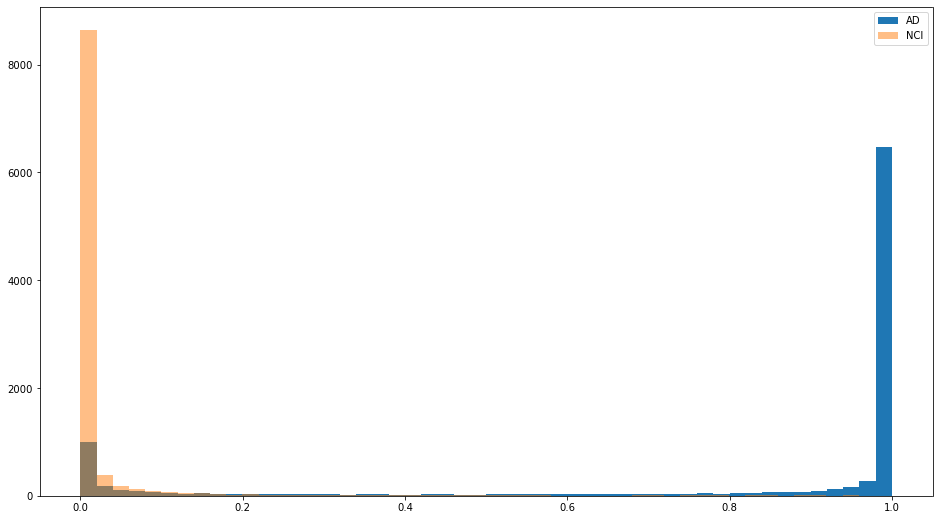

In [5]:
fig,ax = plt.subplots(figsize = (16,9))
plt.hist(finalres[finalres.Pred == 1].LR,bins = 50,label = 'AD')
plt.hist(finalres[finalres.Pred == 0].LR,bins = 50,label = 'NCI',alpha = .5)
plt.legend()

Text(0, 0.5, 'P(AD)')

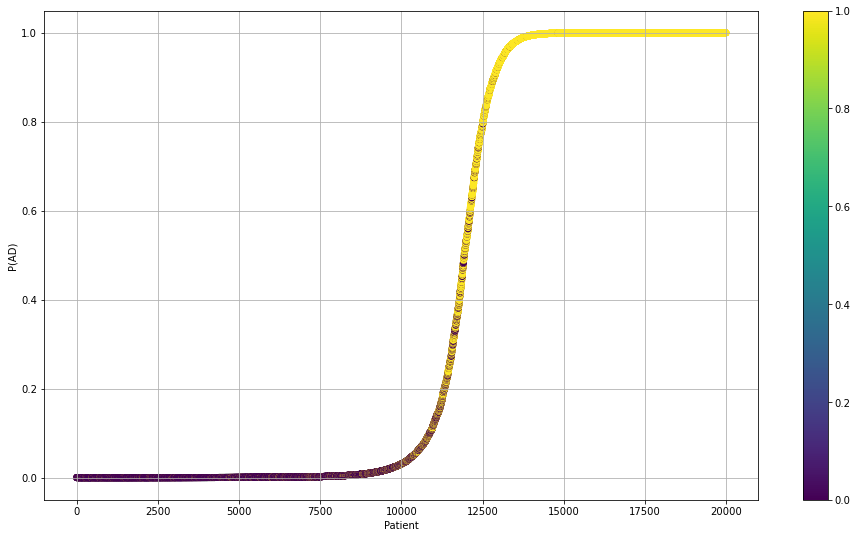

In [6]:
finalres = finalres.sort_values('LR').reset_index(drop=True)
fig,ax = plt.subplots(figsize = (16,9))
cax = plt.scatter(finalres.index,finalres.LR,c=finalres.Pred)
plt.colorbar(cax)
plt.grid()
plt.xlabel('Patient')
plt.ylabel('P(AD)')

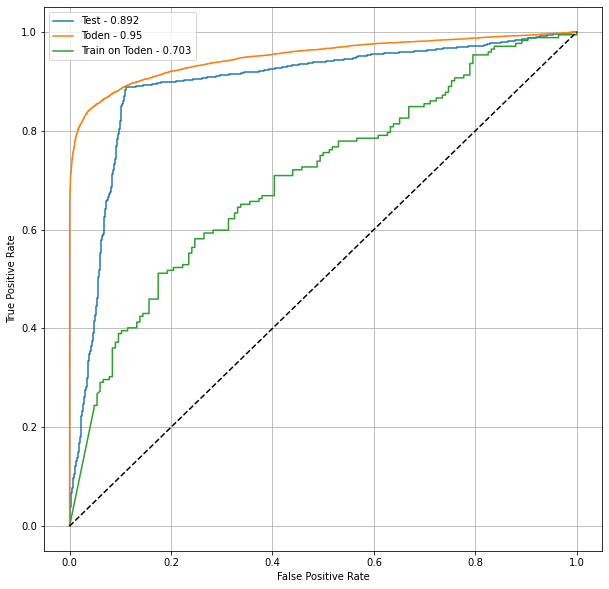

In [8]:
df = pd.concat((scaledBtpms,finalres['Pred']),axis=1)
df = df.sample(frac=1)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]


basisZ = scaler.transform(basisset)
indices = basisset.reset_index().iloc[:,0]

def getlabel(string):
    if 'AD' in string:
        return 1
    else:
        return 0
    
labels = indices.apply(getlabel)

df1 = pd.concat((pd.DataFrame(basisZ),labels),axis=1)
X_toden = df1.iloc[:,:-1]
y_toden = df1.iloc[:,-1]



#split the dataset into training (50%) and testing (50%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

#instantiate the model
log_regression = LogisticRegression(max_iter=100000,random_state=0)

#fit the model using the training data
log_regression.fit(X_train,y_train)
                   

y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test,  y_pred_proba)

fpr1, tpr1, _ = metrics.roc_curve(finalres.Pred,  finalres.LR)
auc1 = metrics.roc_auc_score(finalres.Pred,  finalres.LR)



y_pred_proba = log_regression.predict_proba(X_toden)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_toden,  y_pred_proba)


fig,ax = plt.subplots(figsize = (10,10))
auc2 = metrics.roc_auc_score(y_toden,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label = 'Test - ' + str(np.round(auc,3)))
plt.plot(fpr1,tpr1,label = 'Toden - ' + str(np.round(auc1,3)))
plt.plot(fpr2,tpr2,label = 'Train on Toden - ' + str(np.round(auc2,3)))
plt.plot([0,1],[0,1],'--k')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()